In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor


# Loading Data

If using this code to import, save the dataset as a csv called "Data.csv". Upload it to your notebook and run the following code.

In [2]:
df = pd.read_csv('Data.csv')
df.head()

,index,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,Column1
0,0,02/19/16,2016.0,February,29.0,F,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.000000,80.0,109.0,NaN
1,1,02/20/16,2016.0,February,29.0,F,United States,Washington,Clothing,Gloves,2.0,24.50,28.500000,49.0,57.0,NaN
2,2,02/27/16,2016.0,February,29.0,F,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.000000,11.0,15.0,NaN
3,3,03/12/16,2016.0,March,29.0,F,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.500000,175.0,233.0,NaN
4,4,03/12/16,2016.0,March,29.0,F,United States,Washington,Accessories,Tires and Tubes,3.0,35.00,41.666667,105.0,125.0,NaN


# Data Cleaning

In [3]:
df.shape

(34867, 16)

In [4]:
#dropping index and the random column, redundant
df = df.drop(['index', 'Column1'], axis=1)

In [5]:
rows_with_nan = df[df.isna().any(axis=1)]
rows_with_nan

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue
34866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,641.532095


In [6]:
#dropping indices that have NaN value
dropped_index =df[df.isna().any(axis=1)].index
df = df.drop(dropped_index)
df

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue
0,02/19/16,2016.0,February,29.0,F,United States,Washington,Accessories,Tires and Tubes,1.0,80.00,109.000000,80.0,109.0
1,02/20/16,2016.0,February,29.0,F,United States,Washington,Clothing,Gloves,2.0,24.50,28.500000,49.0,57.0
2,02/27/16,2016.0,February,29.0,F,United States,Washington,Accessories,Tires and Tubes,3.0,3.67,5.000000,11.0,15.0
3,03/12/16,2016.0,March,29.0,F,United States,Washington,Accessories,Tires and Tubes,2.0,87.50,116.500000,175.0,233.0
4,03/12/16,2016.0,March,29.0,F,United States,Washington,Accessories,Tires and Tubes,3.0,35.00,41.666667,105.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,03/22/15,2015.0,March,38.0,M,France,Charente-Maritime,Bikes,Mountain Bikes,1.0,2049.00,1487.000000,2049.0,1487.0
34862,02/07/16,2016.0,February,38.0,M,France,Hauts de Seine,Bikes,Mountain Bikes,2.0,1160.00,985.500000,2320.0,1971.0
34863,03/13/15,2015.0,March,38.0,M,France,Hauts de Seine,Bikes,Mountain Bikes,1.0,2049.00,1583.000000,2049.0,1583.0
34864,04/05/15,2015.0,April,38.0,M,France,Hauts de Seine,Bikes,Mountain Bikes,3.0,683.00,560.666667,2049.0,1682.0


In [7]:
#changed data type of year to integer
df["Year"] = df["Year"].fillna(0).astype(int)
#Customer Age to integer
df['Customer Age'] = df['Customer Age'].astype(int)

#Quantity to integer
df['Quantity'] = df['Quantity'].astype(int)

cat_columns = ['Month', 'Customer Gender', 'Country', 'State', 'Product Category', 'Sub Category']
for col in cat_columns:
    df[col] = df[col].astype('category')

df

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue
0,02/19/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1,80.00,109.000000,80.0,109.0
1,02/20/16,2016,February,29,F,United States,Washington,Clothing,Gloves,2,24.50,28.500000,49.0,57.0
2,02/27/16,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3,3.67,5.000000,11.0,15.0
3,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2,87.50,116.500000,175.0,233.0
4,03/12/16,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3,35.00,41.666667,105.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,03/22/15,2015,March,38,M,France,Charente-Maritime,Bikes,Mountain Bikes,1,2049.00,1487.000000,2049.0,1487.0
34862,02/07/16,2016,February,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,2,1160.00,985.500000,2320.0,1971.0
34863,03/13/15,2015,March,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,1,2049.00,1583.000000,2049.0,1583.0
34864,04/05/15,2015,April,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,3,683.00,560.666667,2049.0,1682.0


In [8]:
#Changing Date to Datetime data type
df["Date"] = pd.to_datetime(df["Date"])
df

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/1788840353.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue
0,2016-02-19,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1,80.00,109.000000,80.0,109.0
1,2016-02-20,2016,February,29,F,United States,Washington,Clothing,Gloves,2,24.50,28.500000,49.0,57.0
2,2016-02-27,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3,3.67,5.000000,11.0,15.0
3,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2,87.50,116.500000,175.0,233.0
4,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3,35.00,41.666667,105.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,2015-03-22,2015,March,38,M,France,Charente-Maritime,Bikes,Mountain Bikes,1,2049.00,1487.000000,2049.0,1487.0
34862,2016-02-07,2016,February,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,2,1160.00,985.500000,2320.0,1971.0
34863,2015-03-13,2015,March,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,1,2049.00,1583.000000,2049.0,1583.0
34864,2015-04-05,2015,April,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,3,683.00,560.666667,2049.0,1682.0


# Feature Engineering

In [9]:
# Adding profit column
df['Profit'] = df['Revenue'] - df['Cost']
df

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,Profit
0,2016-02-19,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1,80.00,109.000000,80.0,109.0,29.0
1,2016-02-20,2016,February,29,F,United States,Washington,Clothing,Gloves,2,24.50,28.500000,49.0,57.0,8.0
2,2016-02-27,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3,3.67,5.000000,11.0,15.0,4.0
3,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2,87.50,116.500000,175.0,233.0,58.0
4,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3,35.00,41.666667,105.0,125.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,2015-03-22,2015,March,38,M,France,Charente-Maritime,Bikes,Mountain Bikes,1,2049.00,1487.000000,2049.0,1487.0,-562.0
34862,2016-02-07,2016,February,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,2,1160.00,985.500000,2320.0,1971.0,-349.0
34863,2015-03-13,2015,March,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,1,2049.00,1583.000000,2049.0,1583.0,-466.0
34864,2015-04-05,2015,April,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,3,683.00,560.666667,2049.0,1682.0,-367.0


In [10]:
#Adding profit margin column
df["Profit Margin"] = df["Profit"] / df["Revenue"]
df

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,Profit,Profit Margin
0,2016-02-19,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1,80.00,109.000000,80.0,109.0,29.0,0.266055
1,2016-02-20,2016,February,29,F,United States,Washington,Clothing,Gloves,2,24.50,28.500000,49.0,57.0,8.0,0.140351
2,2016-02-27,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3,3.67,5.000000,11.0,15.0,4.0,0.266667
3,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2,87.50,116.500000,175.0,233.0,58.0,0.248927
4,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3,35.00,41.666667,105.0,125.0,20.0,0.160000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,2015-03-22,2015,March,38,M,France,Charente-Maritime,Bikes,Mountain Bikes,1,2049.00,1487.000000,2049.0,1487.0,-562.0,-0.377942
34862,2016-02-07,2016,February,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,2,1160.00,985.500000,2320.0,1971.0,-349.0,-0.177067
34863,2015-03-13,2015,March,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,1,2049.00,1583.000000,2049.0,1583.0,-466.0,-0.294378
34864,2015-04-05,2015,April,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,3,683.00,560.666667,2049.0,1682.0,-367.0,-0.218193


In [11]:
age_bins = [0, 18, 25, 35, 45, 55, 65, 100]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Add a new column with the binned ages
df['Age Group'] = pd.cut(df['Customer Age'], bins=age_bins, labels=age_labels, right=False)
df

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,Profit,Profit Margin,Age Group
0,2016-02-19,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1,80.00,109.000000,80.0,109.0,29.0,0.266055,25-34
1,2016-02-20,2016,February,29,F,United States,Washington,Clothing,Gloves,2,24.50,28.500000,49.0,57.0,8.0,0.140351,25-34
2,2016-02-27,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3,3.67,5.000000,11.0,15.0,4.0,0.266667,25-34
3,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2,87.50,116.500000,175.0,233.0,58.0,0.248927,25-34
4,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3,35.00,41.666667,105.0,125.0,20.0,0.160000,25-34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,2015-03-22,2015,March,38,M,France,Charente-Maritime,Bikes,Mountain Bikes,1,2049.00,1487.000000,2049.0,1487.0,-562.0,-0.377942,35-44
34862,2016-02-07,2016,February,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,2,1160.00,985.500000,2320.0,1971.0,-349.0,-0.177067,35-44
34863,2015-03-13,2015,March,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,1,2049.00,1583.000000,2049.0,1583.0,-466.0,-0.294378,35-44
34864,2015-04-05,2015,April,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,3,683.00,560.666667,2049.0,1682.0,-367.0,-0.218193,35-44


In [12]:
df['Numerical Month'] = df['Date'].dt.month

# Define a function to map months to fiscal quarters
def get_quarter(month):
    if month in [3, 1, 2]:
        return 'Q1'
    elif month in [6, 4, 5]:
        return 'Q2'
    elif month in [9, 7, 8]:
        return 'Q3'
    elif month in [12, 10, 11]:
        return 'Q4'
    else:
        return None

# Apply the function to create a new 'Season' column
df['Quarter'] = df['Numerical Month'].apply(get_quarter)
df

,Date,Year,Month,Customer Age,Customer Gender,Country,State,Product Category,Sub Category,Quantity,Unit Cost,Unit Price,Cost,Revenue,Profit,Profit Margin,Age Group,Numerical Month,Quarter
0,2016-02-19,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,1,80.00,109.000000,80.0,109.0,29.0,0.266055,25-34,2,Q1
1,2016-02-20,2016,February,29,F,United States,Washington,Clothing,Gloves,2,24.50,28.500000,49.0,57.0,8.0,0.140351,25-34,2,Q1
2,2016-02-27,2016,February,29,F,United States,Washington,Accessories,Tires and Tubes,3,3.67,5.000000,11.0,15.0,4.0,0.266667,25-34,2,Q1
3,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,2,87.50,116.500000,175.0,233.0,58.0,0.248927,25-34,3,Q1
4,2016-03-12,2016,March,29,F,United States,Washington,Accessories,Tires and Tubes,3,35.00,41.666667,105.0,125.0,20.0,0.160000,25-34,3,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34861,2015-03-22,2015,March,38,M,France,Charente-Maritime,Bikes,Mountain Bikes,1,2049.00,1487.000000,2049.0,1487.0,-562.0,-0.377942,35-44,3,Q1
34862,2016-02-07,2016,February,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,2,1160.00,985.500000,2320.0,1971.0,-349.0,-0.177067,35-44,2,Q1
34863,2015-03-13,2015,March,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,1,2049.00,1583.000000,2049.0,1583.0,-466.0,-0.294378,35-44,3,Q1
34864,2015-04-05,2015,April,38,M,France,Hauts de Seine,Bikes,Mountain Bikes,3,683.00,560.666667,2049.0,1682.0,-367.0,-0.218193,35-44,4,Q2


In [13]:
df.dtypes

Date                datetime64[ns]
Year                         int64
Month                     category
Customer Age                 int64
Customer Gender           category
Country                   category
State                     category
Product Category          category
Sub Category              category
Quantity                     int64
Unit Cost                  float64
Unit Price                 float64
Cost                       float64
Revenue                    float64
Profit                     float64
Profit Margin              float64
Age Group                 category
Numerical Month              int32
Quarter                     object
dtype: object

# EDA

Breakdown of countries and how money products they are selling in each and how much profit they are making.

In [14]:
lst_feat = ['Country', 'Quantity', 'Cost', 'Revenue', 'Profit']
country = df.loc[:,lst_feat].groupby('Country').sum('Profit').sort_values('Profit', ascending = False)
country

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/2002829023.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country = df.loc[:,lst_feat].groupby('Country').sum('Profit').sort_values('Profit', ascending = False)


,Quantity,Cost,Revenue,Profit
Country,,,,
Germany,10386,3285685.0,4244510.0,958825.0
United States,36239,9676577.0,10377742.0,701165.0
United Kingdom,12822,3947265.0,4276220.0,328955.0
France,10373,3173447.0,3446104.0,272657.0


Graphical representation of the country breakdown

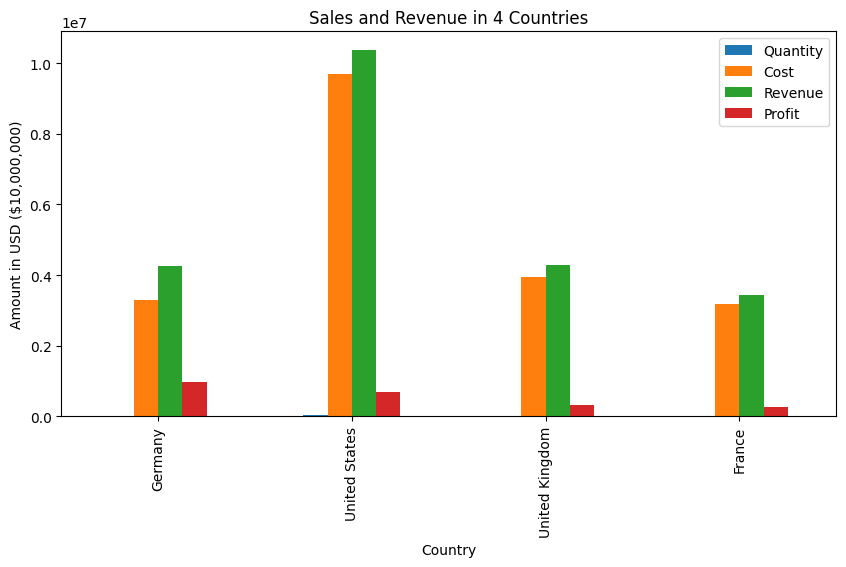

In [15]:
ax = country.plot(kind = 'bar', figsize = (10,5))
ax.set_ylabel('Amount in USD ($10,000,000)')
ax.set_title('Sales and Revenue in 4 Countries')
plt.show()

It seems like the US is where a majority of sales happen, yet it has less profit than Germany. Interesting!!!

Next, let's look at profit by each product being sold.

In [16]:
product = df.groupby(['Sub Category'], as_index = False).sum(numeric_only = True)
product = product[['Sub Category', 'Cost', 'Revenue', 'Profit']].set_index('Sub Category').sort_values('Profit', ascending=False)
product

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/1157554223.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product = df.groupby(['Sub Category'], as_index = False).sum(numeric_only = True)


,Cost,Revenue,Profit
Sub Category,,,
Helmets,2219735.0,2738210.0,518475.0
Tires and Tubes,2353791.0,2865915.0,512124.0
Jerseys,1533234.0,1834110.0,300876.0
Mountain Bikes,5031829.0,5176456.0,144627.0
Bottles and Cages,579840.0,709407.0,129567.0
Road Bikes,3823823.0,3921989.0,98166.0
Touring Bikes,2293102.0,2387910.0,94808.0
Shorts,602140.0,689184.0,87044.0
Hydration Packs,330935.0,403276.0,72341.0


Here is a breakdown of profit by item by country.

In [17]:
product_div = df.groupby(['Country', 'Product Category', 'Sub Category'], as_index = False).sum(numeric_only = True)
product_div = product_div.loc[:, ['Country', 'Product Category', 'Sub Category', 'Quantity', 'Cost', 'Revenue', 'Profit']].sort_values(['Country', 'Product Category', 'Sub Category'])
product_div

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/674928130.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_div = df.groupby(['Country', 'Product Category', 'Sub Category'], as_index = False).sum(numeric_only = True)


,Country,Product Category,Sub Category,Quantity,Cost,Revenue,Profit
0,France,Accessories,Bike Racks,21,9480.0,12456.0,2976.0
1,France,Accessories,Bike Stands,39,17649.0,20398.0,2749.0
2,France,Accessories,Bottles and Cages,1362,78046.0,93406.0,15360.0
3,France,Accessories,Caps,0,0.0,0.0,0.0
4,France,Accessories,Cleaners,104,6261.0,7530.0,1269.0
...,...,...,...,...,...,...,...
199,United States,Clothing,Shorts,904,485310.0,552740.0,67430.0
200,United States,Clothing,Socks,470,32985.0,37975.0,4990.0
201,United States,Clothing,Tires and Tubes,0,0.0,0.0,0.0
202,United States,Clothing,Touring Bikes,0,0.0,0.0,0.0


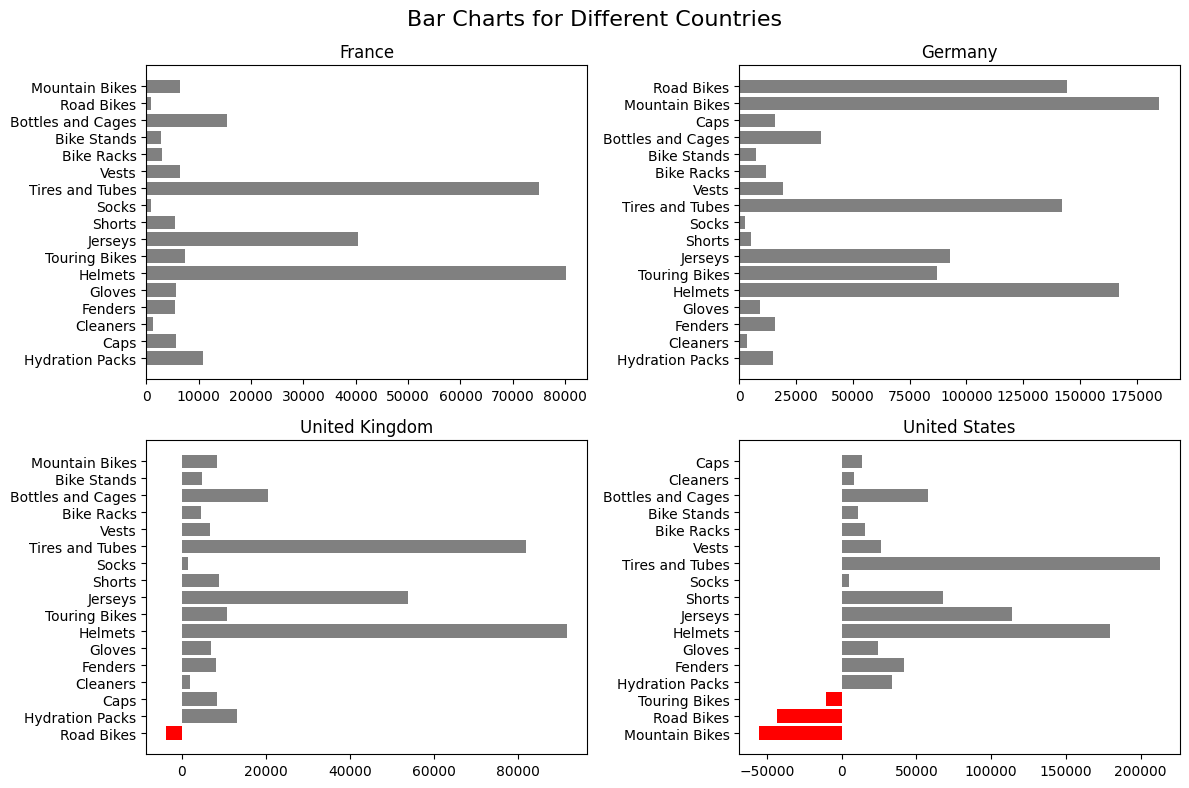

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# List of countries
countries = product_div['Country'].dropna().unique()

# Plot horizontal bar chart and 80% line for each country
for i, country in enumerate(countries):
    country_data = product_div[product_div['Country'] == country].loc[:, ['Sub Category', 'Profit']].sort_values('Profit')

    axs[i // 2, i % 2].barh(country_data['Sub Category'], country_data['Profit'], color=country_data['Profit'].apply(lambda x: 'grey' if x >= 0 else 'red'))
    axs[i // 2, i % 2].set_title(country)

    product_div_sorted = product_div[product_div['Country'] == country].sort_values('Profit', ascending=False).reset_index()
    product_div_sorted['Cumulative Profit %'] = product_div_sorted['Profit'].cumsum() / product_div_sorted['Profit'].sum()

# Add title, readjust the position
fig.suptitle('Bar Charts for Different Countries', fontsize=16)
plt.tight_layout()
plt.show()

NExt let's look at profit by country over time

In [19]:
time = df.groupby(['Country', 'Date'], as_index = False).sum(numeric_only = True).sort_values('Date')
time = time[['Date', 'Country', 'Profit']].set_index('Date')
grouped_data = time.groupby(['Country', time.index.to_period('M')]).sum()
grouped_data

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/3596536871.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time = df.groupby(['Country', 'Date'], as_index = False).sum(numeric_only = True).sort_values('Date')
/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/3596536871.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = time.groupby(['Country', time.index.to_period('M')]).sum()


Profit
Country       Date             
France        2015-01     160.0
              2015-02   -1385.0
              2015-03   -5527.0
              2015-04   -1462.0
              2015-05   -1415.0
...                         ...
United States 2016-03  107580.0
              2016-04  108547.0
              2016-05  133392.0
              2016-06  128213.0
              2016-07   47850.0

[76 rows x 1 columns]

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/2136193753.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = time.groupby('Country')


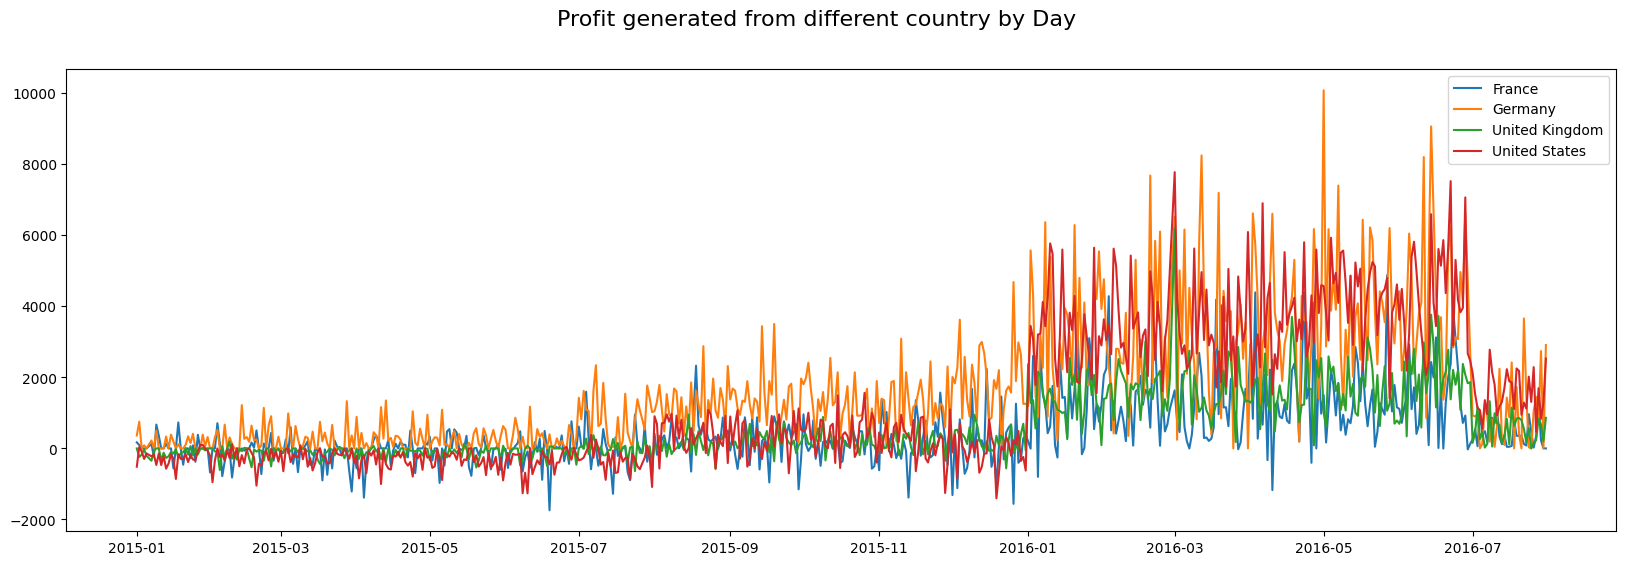

In [20]:
fig, ax = plt.subplots(figsize=(20, 6))

# Group data by 'Country'
grouped_data = time.groupby('Country')

# Iterate through each group and plot the line for each country
for country, group in grouped_data:
    ax.plot(group.index, group['Profit'], label=country)
ax.legend()
fig.suptitle('Profit generated from different country by Day', fontsize = 16)
plt.show()

In [21]:
grouped_data = time.groupby(['Country', time.index.to_period('M')]).sum()
grouped_data

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/562562001.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = time.groupby(['Country', time.index.to_period('M')]).sum()


Profit
Country       Date             
France        2015-01     160.0
              2015-02   -1385.0
              2015-03   -5527.0
              2015-04   -1462.0
              2015-05   -1415.0
...                         ...
United States 2016-03  107580.0
              2016-04  108547.0
              2016-05  133392.0
              2016-06  128213.0
              2016-07   47850.0

[76 rows x 1 columns]

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/1314849687.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for country, group in grouped_data.groupby('Country'):


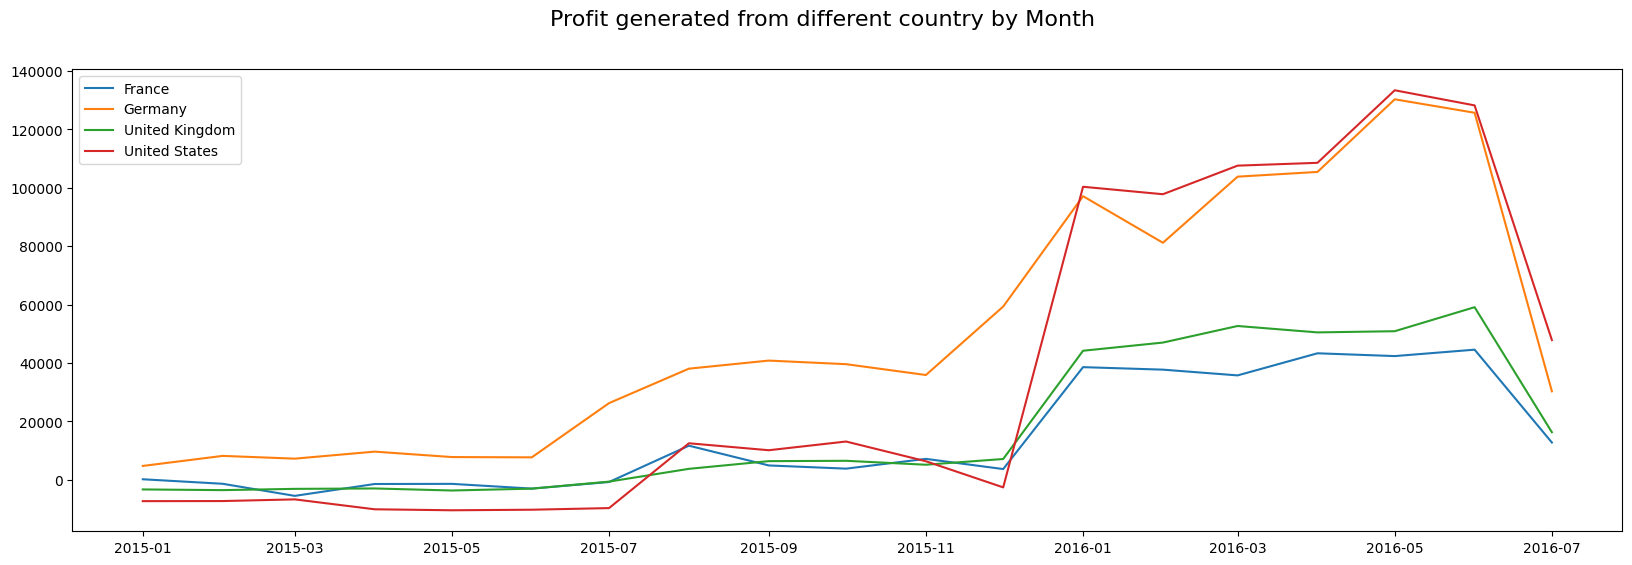

In [22]:
grouped_data = grouped_data.reset_index()
fig, ax = plt.subplots(figsize=(20, 6))

# Turn 'Date' back into a pseudo datetime to create the plot
for country, group in grouped_data.groupby('Country'):
    ax.plot(group['Date'].dt.to_timestamp(), group['Profit'], label=country)
ax.legend()
fig.suptitle('Profit generated from different country by Month', fontsize = 16)
plt.show()

In [23]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

Total_Margin=df.groupby('Month')['Profit'].sum().reindex(month_order)
Bikes_Margin=df[df['Product Category']=='Bikes'].groupby('Month')['Profit'].sum().reindex(month_order)
Accessories_Margin=df[df['Product Category']=='Accessories'].groupby('Month')['Profit'].sum().reindex(month_order)
Clothing_Margin=df[df['Product Category']=='Clothing'].groupby('Month')['Profit'].sum().reindex(month_order)



/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/3747885077.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Total_Margin=df.groupby('Month')['Profit'].sum().reindex(month_order)
/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/3747885077.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Bikes_Margin=df[df['Product Category']=='Bikes'].groupby('Month')['Profit'].sum().reindex(month_order)
/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/3747885077.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versio

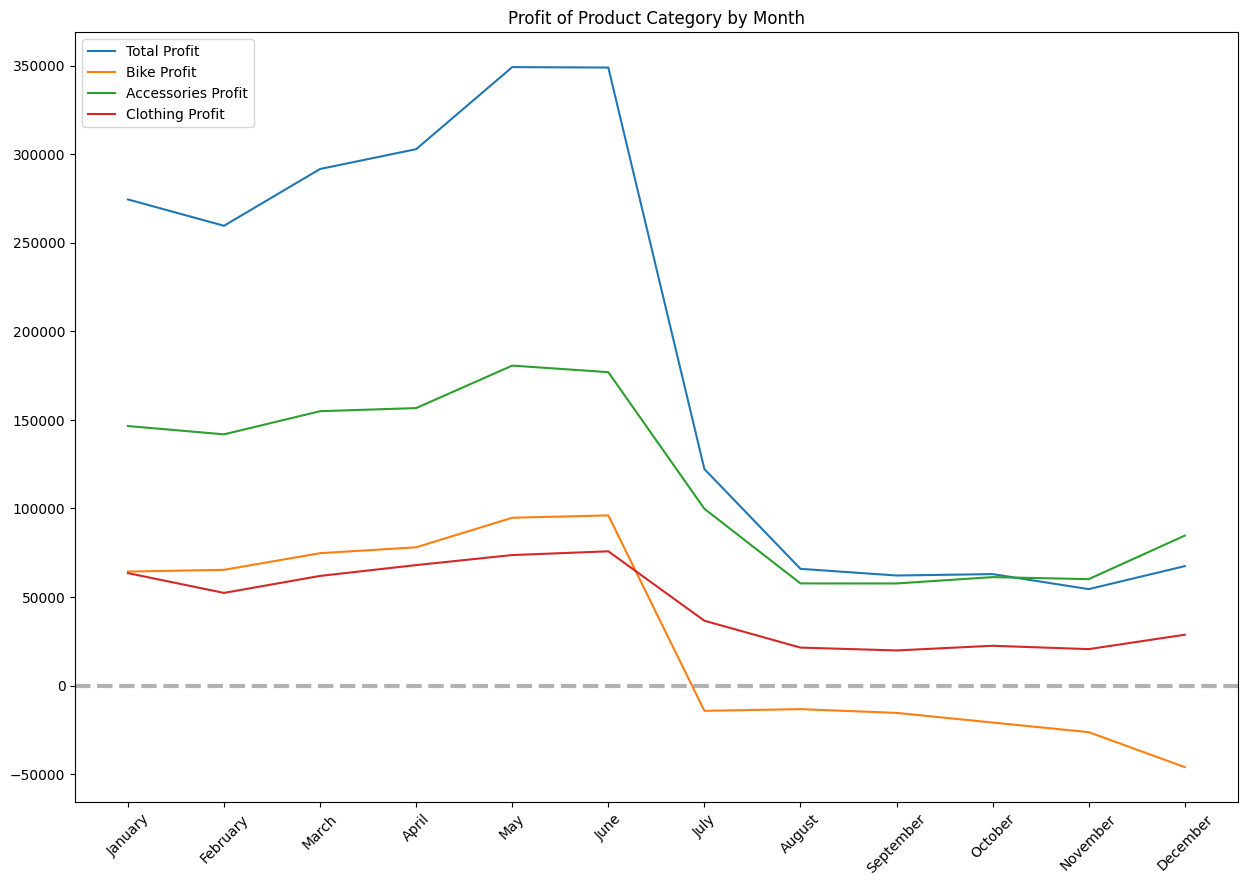

In [24]:
plt.figure(figsize=[15,10])
plt.plot(Total_Margin,label='Total Profit')
plt.plot(Bikes_Margin,label='Bike Profit')
plt.plot(Accessories_Margin,label='Accessories Profit')
plt.plot(Clothing_Margin,label='Clothing Profit')
plt.legend(loc=2)
plt.title('Profit of Product Category by Month')
plt.xticks(rotation=45)
plt.axhline(y=0,color='grey',lw=3,ls='--',alpha=0.6)
plt.show();

Now we will look at demographic breakdowns

In [25]:
df[['Country', 'Customer Gender']].groupby('Country').count()
#pls ignore the gender "column" it's just placeholder to count

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/1312771483.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['Country', 'Customer Gender']].groupby('Country').count()


,Customer Gender
Country,
France,5168
Germany,5201
United Kingdom,6421
United States,18076


In [26]:
df[['Country', 'Customer Gender', 'Profit']].groupby(['Country', 'Customer Gender']).count()
#pls ignore the profit "column" name it's just placeholder to count all the genders lol

/var/folders/np/0s5vgv1x2ll8jyck0fk7fd_40000gn/T/ipykernel_12982/132667408.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[['Country', 'Customer Gender', 'Profit']].groupby(['Country', 'Customer Gender']).count()


Profit
Country        Customer Gender        
France         F                  2595
               M                  2573
Germany        F                  2599
               M                  2602
United Kingdom F                  3168
               M                  3253
United States  F                  8699
               M                  9377

Revenue by age

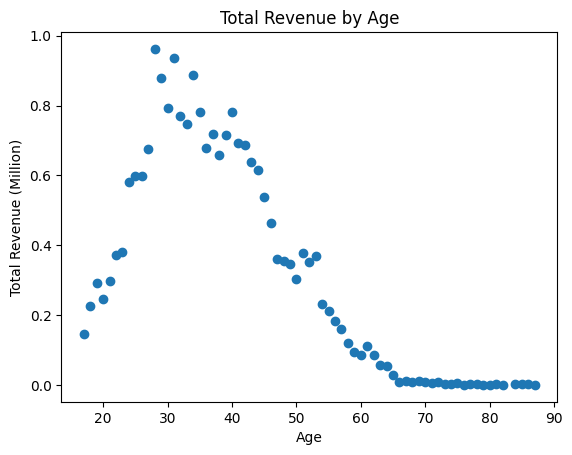

In [27]:
rev_by_age = df.groupby("Customer Age")['Revenue'].sum().reset_index()

# Plot the revenue by age
plt.scatter(rev_by_age["Customer Age"], rev_by_age['Revenue']/1e6)
plt.xlabel('Age')
plt.ylabel("Total Revenue (Million)")
plt.title('Total Revenue by Age')

plt.show()

In [28]:
correlation = np.corrcoef(rev_by_age["Customer Age"], rev_by_age['Revenue'])[0, 1]
# Print the correlation coefficient
print("Correlation Coefficient:", correlation)

Correlation Coefficient: -0.7618512319969879


# VIF

For this, I tried using all the features (including one hot encoding the categorical ones) and deleted the feature with the highest VIF every time until I got the following list where all of the features had under 10! Do with that what you will haha

In [29]:
features_to_use = [
    'Year', 'Customer Age', 'Customer Gender',
    'Product Category', 'Quantity', 'Unit Price',
     'Profit Margin', 'Age Group', 'Quarter'
]

# Drop rows with missing values in the selected columns
df_vif = df[features_to_use].dropna()

# Identify categorical columns for one-hot encoding
categorical_cols = df_vif.select_dtypes(include=['category', 'object']).columns.tolist()

# Identify numerical columns to scale
numerical_cols = df_vif.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

# Apply transformations
X_processed = preprocessor.fit_transform(df_vif)

# Create DataFrame of feature names after encoding
encoded_cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols + list(encoded_cat_cols)

# Compute VIF
vif_df = pd.DataFrame()
vif_df["Feature"] = all_feature_names
vif_df["VIF"] = [variance_inflation_factor(X_processed, i) for i in range(X_processed.shape[1])]

vif_df.sort_values(by="VIF", ascending=False)

,Feature,VIF
1,Customer Age,5.704521
16,Quarter_Q4,5.343456
10,Age Group_45-54,4.813466
0,Year,4.565744
9,Age Group_35-44,3.644436
11,Age Group_55-64,3.577624
15,Quarter_Q3,3.493167
6,Product Category_Bikes,2.781262
8,Age Group_25-34,2.346629
14,Quarter_Q2,2.097599


In [30]:
df_vif.to_csv("cleaned_data.csv", index=False)



**KNN Regression Technique: Predicting Product Demand Based on Customer Clusters**

In [31]:
df_vif.head()

,Year,Customer Age,Customer Gender,Product Category,Quantity,Unit Price,Profit Margin,Age Group,Quarter
0,2016,29,F,Accessories,1,109.000000,0.266055,25-34,Q1
1,2016,29,F,Clothing,2,28.500000,0.140351,25-34,Q1
2,2016,29,F,Accessories,3,5.000000,0.266667,25-34,Q1
3,2016,29,F,Accessories,2,116.500000,0.248927,25-34,Q1
4,2016,29,F,Accessories,3,41.666667,0.160000,25-34,Q1


In [32]:
#features
X = df[['Customer Age', 'Customer Gender', 'Country']]
#target variable
y = df['Quantity']

#encoding categorical columns
X = pd.get_dummies(X)

#Normalize data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [33]:
kmeans = KMeans(n_clusters = 4)
clusters = kmeans.fit_predict(X_scaled)

df['Customer_cluster'] = clusters

In [34]:
from sklearn.model_selection import train_test_split

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2)

#train KNN
knn = KNeighborsRegressor(n_neighbors = 4)
knn.fit(X_train, y_train)

#predict
y_pred = knn.predict(X_test)

In [35]:
from sklearn.metrics import mean_squared_error, r2_score
print("RMSE:", mean_squared_error(y_test, y_pred))
print("r2:", r2_score(y_test, y_pred))

RMSE: 0.8397530111843992
r2: -0.2570880300599532


The RMSE and r2 are not great which means that the KNN model is not able to see patterns in the data. This could mean that the features I selected are not helping the model make good predictions.

In [36]:
X.corr()

,Customer Age,Customer Gender_F,Customer Gender_M,Country_France,Country_Germany,Country_United Kingdom,Country_United States
Customer Age,1.000000,0.021542,-0.021542,-0.043493,-0.057214,-0.034242,0.098286
Customer Gender_F,0.021542,1.000000,-1.000000,0.010680,0.008695,0.003850,-0.016781
Customer Gender_M,-0.021542,-1.000000,1.000000,-0.010680,-0.008695,-0.003850,0.016781
Country_France,-0.043493,0.010680,-0.010680,1.000000,-0.174670,-0.198197,-0.432836
Country_Germany,-0.057214,0.008695,-0.008695,-0.174670,1.000000,-0.198939,-0.434457
Country_United Kingdom,-0.034242,0.003850,-0.003850,-0.198197,-0.198939,1.000000,-0.492974
Country_United States,0.098286,-0.016781,0.016781,-0.432836,-0.434457,-0.492974,1.000000


**KNN Classification**

In [37]:
X = df[['Customer Age', 'Customer Gender', 'Country']]
X = pd.get_dummies(X)

y = df['Product Category']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3)

In [38]:
#training KNN classifer
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [39]:
from sklearn.metrics import accuracy_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("f1", f1_score(y_test, y_pred, average = 'weighted'))

Accuracy: 0.6101338432122371
f1 0.5272417248294633


The accuracy and f1 score are pretty low which might suggest that the features I selected might not be sufficient information to make this prediction. It could also mean that KNN is not a good model to make this type of prediction.